# Лабораторная работа 6.1. Transfer learning сверточных нейронных сетей

### Работу выполнил:<span style="color:blue"> Михаил Батухтин</span>

### Сделанную лабораторную работу отправляйте через [ФОРМУ](https://vyatsu-my.sharepoint.com/:f:/g/personal/usr09019_vyatsu_ru/EpSy8Xu4FxhMklHgj0NBX-4B1VnXTBIs4-D3Oi74j0wcGQ)

Необходимо дообучить свёрточню сеть ResNet50 для решения задачи классификации изображений из предыдущей лабораторной работы.
Ниже приводится пример дообучения нейронной сети в PyTorch, взятый по [ссылке](https://github.com/spmallick/learnopencv/tree/master/Image-Classification-in-PyTorch).

Задание считается выполненным при достижении accuracy=0.9 на тестовом наборе данных.

In [1]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
image_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [3]:
dataset = '../data'

train_directory = os.path.join(dataset, 'seg_train/seg_train')
valid_directory = os.path.join(dataset, 'seg_test/seg_test')
test_directory = os.path.join(dataset, 'seg_test/seg_test')

bs = 32

# Number of classes
num_classes = len(os.listdir(train_directory))
print(f"Number of classes: {num_classes}")

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print("Class mapping:", idx_to_class)

# Size of Data
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

Number of classes: 6
Class mapping: {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Dataset sizes - Train: {train_data_size}, Valid: {valid_data_size}, Test: {test_data_size}")

Using device: cuda:0
Dataset sizes - Train: 14034, Valid: 3000, Test: 3000


In [5]:
resnet50 = models.resnet50(pretrained=True)
resnet50 = resnet50.to(device)

# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes),
    nn.LogSoftmax(dim=1)
)

# Convert model to be used on GPU
resnet50 = resnet50.to(device)

C:\Users\giezz\PycharmProjects\computer-vision\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\giezz\PycharmProjects\computer-vision\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    start = time.time()
    history = []
    best_loss = 100000.0
    best_epoch = None
    best_model_state = None

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))

        # Set to training mode
        model.train()

        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0

        valid_loss = 0.0
        valid_acc = 0.0

        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Clean existing gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Backpropagate
            loss.backward()

            # Update parameters
            optimizer.step()

            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)

            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and compute mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch
            train_acc += acc.item() * inputs.size(0)

        # Validation
        with torch.no_grad():
            model.eval()

            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = loss_criterion(outputs, labels)

                valid_loss += loss.item() * inputs.size(0)

                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))
                acc = torch.mean(correct_counts.type(torch.FloatTensor))
                valid_acc += acc.item() * inputs.size(0)

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            best_model_state = model.state_dict().copy()

        # Find average losses and accuracy
        avg_train_loss = train_loss/train_data_size
        avg_train_acc = train_acc/train_data_size
        avg_valid_loss = valid_loss/valid_data_size
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])

        epoch_end = time.time()

        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss: {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(
            epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))

        # Save model checkpoint
        torch.save(model.state_dict(), f"{dataset}_model_{epoch}.pth")

    # Load best model state
    model.load_state_dict(best_model_state)
    return model, history, best_epoch


In [7]:
num_epochs = 20
trained_model, history, best_epoch = train_and_validate(resnet50, loss_func, optimizer, num_epochs)

# Save final model and history
torch.save(trained_model.state_dict(), f"{dataset}_final_model.pth")
torch.save(history, f"{dataset}_history.pt")

Epoch: 1/20
Epoch : 000, Training: Loss: 0.5194, Accuracy: 80.6114%, 
		Validation : Loss: 0.2904, Accuracy: 89.3667%, Time: 64.1721s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.3940, Accuracy: 85.1575%, 
		Validation : Loss: 0.2776, Accuracy: 89.8667%, Time: 56.9286s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.3740, Accuracy: 86.5185%, 
		Validation : Loss: 0.2774, Accuracy: 89.5000%, Time: 53.7228s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.3627, Accuracy: 86.6396%, 
		Validation : Loss: 0.2757, Accuracy: 89.8333%, Time: 53.3779s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.3490, Accuracy: 87.1099%, 
		Validation : Loss: 0.2697, Accuracy: 89.9000%, Time: 53.4222s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.3477, Accuracy: 87.1313%, 
		Validation : Loss: 0.2600, Accuracy: 90.2000%, Time: 53.2528s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.3408, Accuracy: 87.4163%, 
		Validation : Loss: 0.2528, Accuracy: 90.4667%, Time: 53.3376s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.3339, Accuracy: 87.

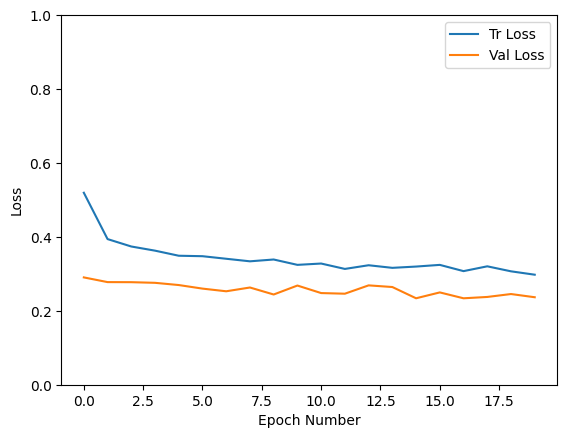

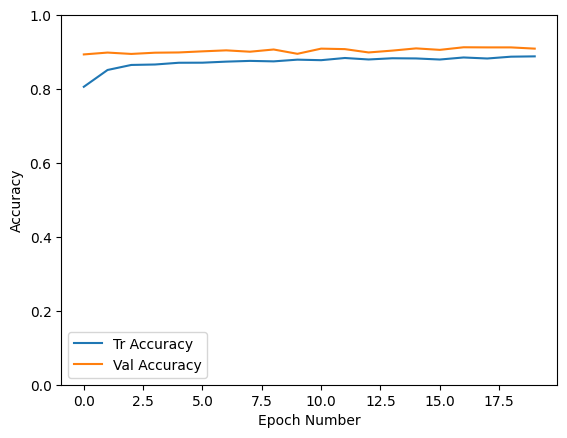

In [8]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(f'{dataset}_loss_curve.png')
plt.show()

# Plot accuracy curve
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(f'{dataset}_accuracy_curve.png')
plt.show()

In [9]:
def computeTestSetAccuracy(model, loss_criterion):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.eval()

    test_acc = 0.0
    test_loss = 0.0

    with torch.no_grad():
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = loss_criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)

            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            test_acc += acc.item() * inputs.size(0)

    avg_test_loss = test_loss/test_data_size
    avg_test_acc = test_acc/test_data_size

    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc:.4f}")

def predict(model, test_image_name):
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    plt.show()

    test_image_tensor = transform(test_image)
    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)

    with torch.no_grad():
        model.eval()
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)

        for i in range(3):
            print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]],
                  ", Score: ", topk.cpu().numpy()[0][i])

In [10]:
model = trained_model
computeTestSetAccuracy(model, loss_func)

Test Loss: 0.2367, Test Accuracy: 0.9093
